# Part 2: Basics

## Recap

In [89]:
# imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [90]:
# load data
data_titanic = pd.read_csv("titanic.csv", index_col="PassengerId")

In [91]:
data_titanic.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
# define input
# * drop our target "Survived"
# * only select numbers
# * drop samples with undefined values (only in column "Age" in our case)
X = data_titanic.drop(columns="Survived").select_dtypes(np.number).dropna()

# define our target/output and only select those samples left in X
y = data_titanic["Survived"][X.index]

In [93]:
X.head(5)

,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,
1,3,22.0,1,0,7.2500
2,1,38.0,1,0,71.2833
3,3,26.0,0,0,7.9250
4,1,35.0,1,0,53.1000
5,3,35.0,0,0,8.0500


In [94]:
# select and fit out model
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [95]:
# make predictions
y_pred = model.predict(X)
y_pred[:5]

array([0, 1, 0, 1, 0])

## Connecting `LogisticRegression` to formulas in the script

In [98]:
# logistic regression returns "probabilities" 
# each lines shows the probability for [NOT "Survived", "Survived"]
y_pred_proba = model.predict_proba(X)
y_pred_proba[:5,:]

array([[0.78448636, 0.21551364],
       [0.38056441, 0.61943559],
       [0.76449122, 0.23550878],
       [0.36473681, 0.63526319],
       [0.82817097, 0.17182903]])

How are these probabilities derived?

* Remember the formula for logistic regression: $y_i = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_m x_m$
* As well as the logistic function: $f(x) = \frac{1}{1 + e^{-x}}$

In [119]:
# first extract betas from the fit LogisticRegression model
beta0 = model.intercept_
betas = model.coef_

In [106]:
# apply linear regression formula
results = beta0 + np.sum(betas * X, axis=1)
results

PassengerId
1     -1.292005
2      0.487153
3     -1.177462
4      0.554863
5     -1.572720
         ...   
886   -0.470285
887   -0.075225
888    1.464807
890    1.157042
891   -1.441879
Length: 714, dtype: float64

In [111]:
# apply logistic formula
def logistic(x):
    return 1 / (1 + np.exp(-x))
results_logistic = logistic(results)

In [120]:
# compare probabilities for `Survived` from the model and the ones we calculated
print(y_pred_proba[:5,1])
print(results_logistic.head(5).values)

[0.21551364 0.61943559 0.23550878 0.63526319 0.17182903]
[0.21551364 0.61943559 0.23550878 0.63526319 0.17182903]


## Evaluation measures

How to evaluate models? We compare the correct class with the prediction values (which can either be a class or a probability for the target class). There are many different mesasures.

In [32]:
# inspect the correct class
y.values[:5]

array([0, 1, 1, 1, 0])

In [121]:
# inspect the predicted class
y_pred[:5]

array([0, 1, 0, 1, 0])

In [125]:
# several scores when the prediction is a class (not a probability)
from sklearn.metrics import accuracy_score, precision_score, recall_score

$accuracy = \frac{\text{true positives} ~+~ \text{true negatives}}{\text{number of samples}}$

In [128]:
accuracy_score(y, y_pred)

0.7002801120448179

$precision = \frac{\text{true positives}}{\text{true positives} ~+~ \text{false positives}}$

In [129]:
precision_score(y, y_pred)

0.6696428571428571

$recall = \frac{\text{true positives}}{\text{true positives} ~+~ \text{false negatives}}$

In [37]:
recall_score(y_pred, y)

0.6696428571428571

In [132]:
# AUC: scores for when the prediction is a probability
from sklearn.metrics import roc_auc_score, roc_curve

In [154]:
auc = roc_auc_score(y, y_pred_proba[:,1])
auc

0.7586410214703969

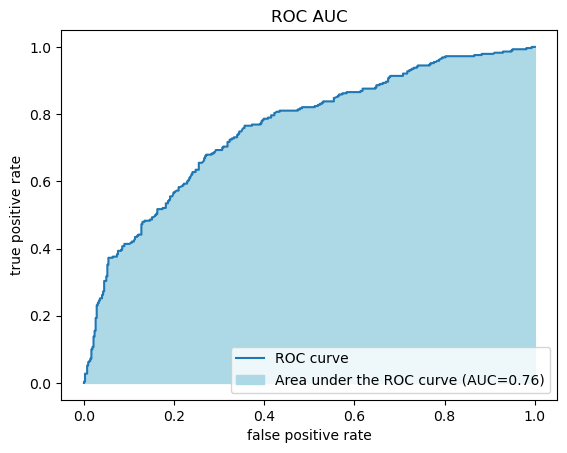

In [157]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1], pos_label=1)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC curve")
ax.fill_between(fpr, tpr, color="lightblue", label=f"Area under the ROC curve (AUC={auc:.02f})")
ax.set(title="ROC AUC", xlabel="false positive rate", ylabel="true positive rate")
ax.legend()

## Validation

In [162]:
# before inspecting the data, selecting and building models, etc. 
# FIRST split data into train and test data (we set the test data size to 30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Approach 1: Validation set

* split training into a smaller training and validation data
* select, fit and evaluate model on training data
* after finishing, test the model on the test data

This approach is often used when the training data is large. Because we assume that the validation data is characteristically similar to the training data.

In [241]:
# split training into a smaller training and a validation dataset
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [242]:
# try first model
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train_small, y_train_small)
y_pred_proba = model1.predict_proba(X_val)
roc_auc_score(y_val, y_pred_proba[:,1])

0.7553282182438193

In [243]:
# try second model
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()
model2.fit(X_train_small, y_train_small)
y_pred_proba = model2.predict_proba(X_val)
roc_auc_score(y_val, y_pred_proba[:,1])

0.6939471440750212

In [183]:
# logistic regression is better, so retrain on the full training data an apply to test
model1.fit(X_train, y_train)
y_pred_proba = model1.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.7247807017543859

### Approach 2: Cross-validation

* use cross validation to select, fit and evaluate model on training data
* after finishing, refit the model on the whole training data, and test the model on the test data

This approach is often used when not a lot of data is available. It ensures that the result is not dependent on a particular good or bad split.

In [248]:
from sklearn.model_selection import cross_val_score

In [249]:
# try first model
model1 = LogisticRegression()
scores = cross_val_score(model1, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.7772837265577737, 0.049249803802039534)

In [252]:
# try second model
model2 = DecisionTreeClassifier()
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.6079673321234119, 0.03129196516091729)

In [251]:
# logistic regression is better, so retrain on the full training data an apply to test
model1.fit(X_train, y_train)
y_pred_proba = model1.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.7247807017543859

## Overfitting and underfitting

In [235]:
# note: these should have tried these models BEFORE EVER touching the test data

In [253]:
# try bagging which helps against overfitting (we currently don't overfit though, i.e., we do only get mediocre AUCs on the training data)
from sklearn.ensemble import BaggingClassifier
model3 = BaggingClassifier(LogisticRegression(), n_estimators=10)
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.780151240169389, 0.04627954877047133)

In [254]:
# try boosting which helps against underfitting and is relatively robust against overfitting
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier()
scores = cross_val_score(model4, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.7396430732002419, 0.047999627403040805)

## Hyperparameters

In [234]:
# note: these should have tried these models BEFORE EVER touching the test data

In [210]:
# let's try logistic regression with ridge regularization
from sklearn.linear_model import RidgeClassifier
model5 = RidgeClassifier() 
scores = cross_val_score(model5, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.7807924984875982, 0.045730353743235475)

In [213]:
# but ridge regression has a hyperparameter (how stronlgy regularization is taken into account [here: alpha, script: lambda])
# let's automatically optimize it using an "inner" cross validation (automatically done by GridSearchCV)
from sklearn.model_selection import GridSearchCV
model6 = GridSearchCV(RidgeClassifier(), param_grid={"alpha": [0.1,0.3,0.5,0.7,0.9]})
scores = cross_val_score(model5, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.7807924984875982, 0.045730353743235475)

In [216]:
# refit model on train and check the selected alpha parameter
model6.fit(X_train, y_train)
model6.best_estimator_

RidgeClassifier(alpha=0.1)

In [223]:
y_pred_proba = model1.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.7247807017543859

In [221]:
# let's try parameter optimization for decision trees
model7 = GridSearchCV(DecisionTreeClassifier(), param_grid={"max_depth": [2,4,8,16,32]})
scores = cross_val_score(model7, X_train, y_train, cv=5, scoring="roc_auc")
np.mean(scores), np.std(scores)

(0.6482577132486389, 0.05308526532953746)

In [225]:
# refit model on train and check the selected alpha parameter
model7.fit(X_train, y_train)
model7.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [238]:
# observe how the optimized tree is actually better than when using a vanilla tree (see above) 
y_pred_proba = model7.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.6919298245614035